In [130]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [131]:
from google.colab import drive
drive.mount('/content/drive')
relative_path = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
train_dataset = pd.read_csv('/content/drive/My Drive/cs-training.csv')
test_dataset = pd.read_csv('/content/drive/My Drive/cs-test.csv')

In [133]:
train_dataset = train_dataset.drop(columns={'Unnamed: 0'})
test_dataset = test_dataset.drop(columns={'Unnamed: 0', 'SeriousDlqin2yrs'})

In [134]:
train_dataset.shape, test_dataset.shape

((150000, 11), (101503, 10))

In [135]:
train_dataset.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [136]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [137]:
train_dataset.isnull().sum().max()
test_dataset.isnull().sum().max()

20103

In [138]:
#train_dataset.MonthlyIncome = train_dataset.MonthlyIncome.fillna(train_dataset.MonthlyIncome.median())
#test_dataset.MonthlyIncome = test_dataset.MonthlyIncome.fillna(test_dataset.MonthlyIncome.median())

In [139]:
train_dataset.columns, test_dataset.columns

(Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
        'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
        'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
        'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfDependents'],
       dtype='object'), Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
        'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
        'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
        'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfDependents'],
       dtype='object'))

In [140]:
# The classes are heavily skewed we need to solve this issue later.
print('No Defaults', round(train_dataset['SeriousDlqin2yrs'].value_counts()[0]/len(train_dataset) * 100,2), '% of the dataset')
print('Defaults', round(train_dataset['SeriousDlqin2yrs'].value_counts()[1]/len(train_dataset) * 100,2), '% of the dataset')

No Defaults 93.32 % of the dataset
Defaults 6.68 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Default || 1: Default)')

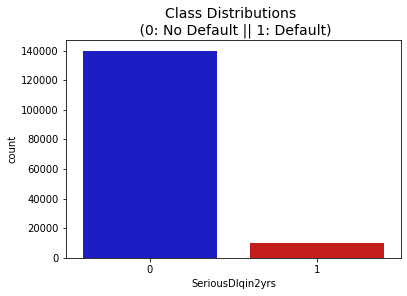

In [141]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('SeriousDlqin2yrs', data=train_dataset, palette=colors)
plt.title('Class Distributions \n (0: No Default || 1: Default)', fontsize=14)

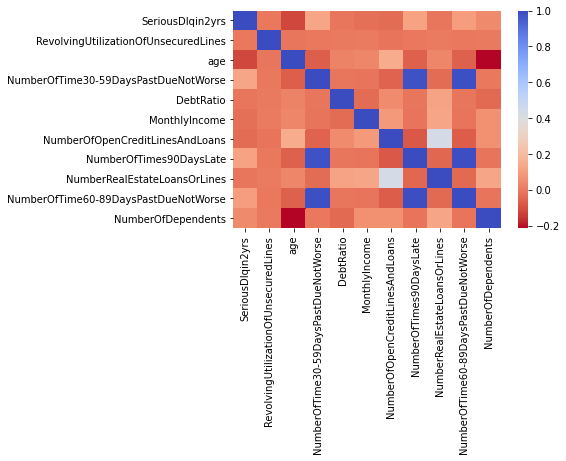

In [142]:
#correlation matrix
corr = train_dataset.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

In [143]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

train_dataset['scaled_age'] = std_scaler.fit_transform(train_dataset['age'].values.reshape(-1,1))
train_dataset['scaled_RevolvingUtilizationOfUnsecuredLines'] = std_scaler.fit_transform(train_dataset['RevolvingUtilizationOfUnsecuredLines'].values.reshape(-1,1))
train_dataset['scaled_DebtRatio'] = std_scaler.fit_transform(train_dataset['DebtRatio'].values.reshape(-1,1))
train_dataset['scaled_MonthlyIncome'] = std_scaler.fit_transform(train_dataset['MonthlyIncome'].values.reshape(-1,1))
train_dataset['scaled_NumberOfOpenCreditLinesAndLoans'] = std_scaler.fit_transform(train_dataset['NumberOfOpenCreditLinesAndLoans'].values.reshape(-1,1))

train_dataset.drop(['age','RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans'], axis=1, inplace=True)

In [144]:
scaled_age = train_dataset['scaled_age']
scaled_RevolvingUtilizationOfUnsecuredLines = train_dataset['scaled_RevolvingUtilizationOfUnsecuredLines']
scaled_DebtRatio = train_dataset['scaled_DebtRatio']
scaled_MonthlyIncome = train_dataset['scaled_MonthlyIncome']
scaled_NumberOfOpenCreditLinesAndLoans = train_dataset['scaled_NumberOfOpenCreditLinesAndLoans']

train_dataset.drop(['scaled_age', 'scaled_RevolvingUtilizationOfUnsecuredLines', 'scaled_DebtRatio', 'scaled_MonthlyIncome', 'scaled_NumberOfOpenCreditLinesAndLoans'], axis=1, inplace=True)

train_dataset.insert(1, 'scaled_age', scaled_age)
train_dataset.insert(2, 'scaled_RevolvingUtilizationOfUnsecuredLines', scaled_RevolvingUtilizationOfUnsecuredLines)
train_dataset.insert(3, 'scaled_DebtRatio', scaled_DebtRatio)
train_dataset.insert(4, 'scaled_MonthlyIncome', scaled_MonthlyIncome)
train_dataset.insert(5, 'scaled_NumberOfOpenCreditLinesAndLoans', scaled_NumberOfOpenCreditLinesAndLoans)

train_dataset.head()

,SeriousDlqin2yrs,scaled_age,scaled_RevolvingUtilizationOfUnsecuredLines,scaled_DebtRatio,scaled_MonthlyIncome,scaled_NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,-0.493860,-0.021150,-0.172833,0.170305,0.883657,2,0,6,0,2.0
1,0,-0.832342,-0.020385,-0.173168,-0.282957,-0.865297,0,0,0,0,1.0
2,0,-0.967735,-0.021582,-0.173186,-0.252229,-1.253953,1,1,0,0,0.0
3,0,-1.509307,-0.023281,-0.173210,-0.234293,-0.670969,0,0,0,0,0.0
4,0,-0.223074,-0.020585,-0.173215,3.956851,-0.282312,1,0,1,0,0.0


In [145]:
test_dataset['scaled_age'] = std_scaler.fit_transform(test_dataset['age'].values.reshape(-1,1))
test_dataset['scaled_RevolvingUtilizationOfUnsecuredLines'] = std_scaler.fit_transform(test_dataset['RevolvingUtilizationOfUnsecuredLines'].values.reshape(-1,1))
test_dataset['scaled_DebtRatio'] = std_scaler.fit_transform(test_dataset['DebtRatio'].values.reshape(-1,1))
test_dataset['scaled_MonthlyIncome'] = std_scaler.fit_transform(test_dataset['MonthlyIncome'].values.reshape(-1,1))
test_dataset['scaled_NumberOfOpenCreditLinesAndLoans'] = std_scaler.fit_transform(test_dataset['NumberOfOpenCreditLinesAndLoans'].values.reshape(-1,1))

test_dataset.drop(['age','RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans'], axis=1, inplace=True)

In [146]:
scaled_age = test_dataset['scaled_age']
scaled_RevolvingUtilizationOfUnsecuredLines = test_dataset['scaled_RevolvingUtilizationOfUnsecuredLines']
scaled_DebtRatio = test_dataset['scaled_DebtRatio']
scaled_MonthlyIncome = test_dataset['scaled_MonthlyIncome']
scaled_NumberOfOpenCreditLinesAndLoans = test_dataset['scaled_NumberOfOpenCreditLinesAndLoans']

test_dataset.drop(['scaled_age', 'scaled_RevolvingUtilizationOfUnsecuredLines', 'scaled_DebtRatio', 'scaled_MonthlyIncome', 'scaled_NumberOfOpenCreditLinesAndLoans'], axis=1, inplace=True)

test_dataset.insert(1, 'scaled_age', scaled_age)
test_dataset.insert(2, 'scaled_RevolvingUtilizationOfUnsecuredLines', scaled_RevolvingUtilizationOfUnsecuredLines)
test_dataset.insert(3, 'scaled_DebtRatio', scaled_DebtRatio)
test_dataset.insert(4, 'scaled_MonthlyIncome', scaled_MonthlyIncome)
test_dataset.insert(5, 'scaled_NumberOfOpenCreditLinesAndLoans', scaled_NumberOfOpenCreditLinesAndLoans)

test_dataset.head()

,NumberOfTime30-59DaysPastDueNotWorse,scaled_age,scaled_RevolvingUtilizationOfUnsecuredLines,scaled_DebtRatio,scaled_MonthlyIncome,scaled_NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,-0.636376,-0.022556,-0.210891,-0.031638,-0.865756,0,0,0,0.0
1,0,0.310870,-0.024709,-0.210677,0.062615,1.272627,0,4,0,2.0
2,0,0.446191,-0.026850,-0.210578,-0.048538,0.689431,0,1,0,2.0
3,1,-0.974678,-0.025641,-0.210432,-0.100115,-0.282561,0,2,0,0.0
4,0,-1.718943,-0.021972,-0.210987,-0.081900,-0.865756,0,0,0,1.0


Splitting the Data (Original DataFrame)

Before proceeding with the Random UnderSampling technique we have to separate the orginal dataframe for testing purposes. Although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Defaults', round(train_dataset['SeriousDlqin2yrs'].value_counts()[0]/len(train_dataset) * 100,2), '% of the dataset')
print('Defaults', round(train_dataset['SeriousDlqin2yrs'].value_counts()[1]/len(train_dataset) * 100,2), '% of the dataset')

X = train_dataset.drop('SeriousDlqin2yrs', axis=1)
y = train_dataset['SeriousDlqin2yrs']

X.scaled_MonthlyIncome = X.scaled_MonthlyIncome.fillna(X.scaled_MonthlyIncome.median())
X.NumberOfDependents = X.NumberOfDependents.fillna(X.NumberOfDependents.median())

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why we're using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Defaults 93.32 % of the dataset
Defaults 6.68 % of the dataset
Train: [ 29931  29932  29933 ... 149997 149998 149999] Test: [    0     1     2 ... 30887 30945 30986]
Train: [     0      1      2 ... 149997 149998 149999] Test: [29931 29932 29933 ... 60044 60047 60053]
Train: [     0      1      2 ... 149997 149998 149999] Test: [59995 59996 59997 ... 90908 90961 90962]
Train: [     0      1      2 ... 149997 149998 149999] Test: [ 89945  89946  89947 ... 120571 120572 120576]
Train: [     0      1      2 ... 120571 120572 120576] Test: [119958 119959 119960 ... 149997 149998 149999]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.93315833 0.06684167]
[0.93316667 0.06683333]


Random Under-Sampling:

In [148]:
print(train_dataset['SeriousDlqin2yrs'].value_counts()[0])
print(train_dataset['SeriousDlqin2yrs'].value_counts()[1])

139974
10026


In [149]:
## Separate train features and label 
train_dataset["SeriousDlqin2yrs"] = train_dataset["SeriousDlqin2yrs"].astype(int)
y_train_dataset = train_dataset["SeriousDlqin2yrs"]
X_train_dataset = train_dataset.drop(labels = ["SeriousDlqin2yrs"],axis = 1)

In [150]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = train_dataset.sample(frac=1, axis=1)

# amount of fraud classes 492 rows.
default_df = train_dataset.loc[train_dataset['SeriousDlqin2yrs'] == 1]
non_default_df = train_dataset.loc[train_dataset['SeriousDlqin2yrs'] == 0][:10026]

normal_distributed_df = pd.concat([default_df, non_default_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,SeriousDlqin2yrs,scaled_age,scaled_RevolvingUtilizationOfUnsecuredLines,scaled_DebtRatio,scaled_MonthlyIncome,scaled_NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
6705,0,-0.358467,-0.021106,-0.173091,0.350359,0.106344,0,0,1,0,3.0
74603,1,0.115409,-0.020133,-0.172982,-0.220390,0.495001,1,0,0,0,0.0
6452,0,-0.019984,-0.022813,-0.173119,0.161963,0.300672,0,0,1,0,1.0
4365,0,-0.561556,-0.023191,-0.172869,-0.102208,1.077985,0,0,3,0,1.0
5823,0,1.672428,-0.024218,0.497099,NaN,-0.865297,0,0,1,0,0.0


Equally Distributing and Correlating:

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: SeriousDlqin2yrs, dtype: float64


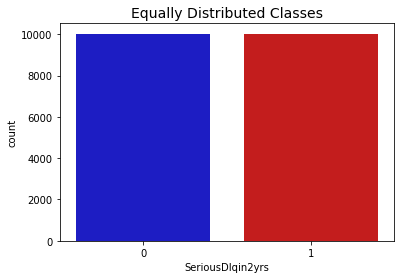

In [151]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['SeriousDlqin2yrs'].value_counts()/len(new_df))

sns.countplot('SeriousDlqin2yrs', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

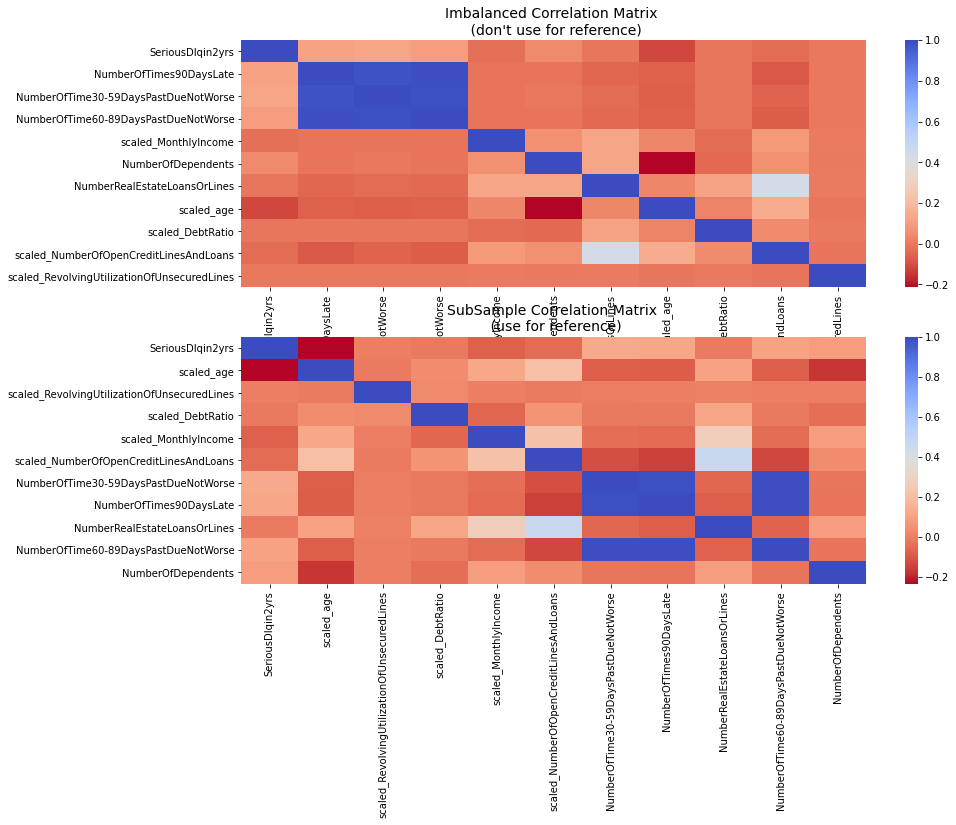

In [152]:
# Make sure we use the subsample in our correlation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

Anomaly Detection:

In [153]:
# Lets check for outliers in the dataset
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(new_df,2,["scaled_RevolvingUtilizationOfUnsecuredLines",
                                            "scaled_age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "scaled_DebtRatio",
                                            "scaled_MonthlyIncome",
                                            "scaled_NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "NumberOfDependents"])

Dimensionality Reduction and Clustering:

In [154]:
new_df.isna().sum()

SeriousDlqin2yrs                                  0
scaled_age                                        0
scaled_RevolvingUtilizationOfUnsecuredLines       0
scaled_DebtRatio                                  0
scaled_MonthlyIncome                           3646
scaled_NumberOfOpenCreditLinesAndLoans            0
NumberOfTime30-59DaysPastDueNotWorse              0
NumberOfTimes90DaysLate                           0
NumberRealEstateLoansOrLines                      0
NumberOfTime60-89DaysPastDueNotWorse              0
NumberOfDependents                              463
dtype: int64

In [155]:
new_df.scaled_MonthlyIncome = new_df.scaled_MonthlyIncome.fillna(new_df.scaled_MonthlyIncome.median())
new_df.NumberOfDependents = new_df.NumberOfDependents.fillna(new_df.NumberOfDependents.median())
test_dataset.scaled_MonthlyIncome = test_dataset.scaled_MonthlyIncome.fillna(test_dataset.scaled_MonthlyIncome.median())

In [156]:
new_df.isna().sum()

SeriousDlqin2yrs                               0
scaled_age                                     0
scaled_RevolvingUtilizationOfUnsecuredLines    0
scaled_DebtRatio                               0
scaled_MonthlyIncome                           0
scaled_NumberOfOpenCreditLinesAndLoans         0
NumberOfTime30-59DaysPastDueNotWorse           0
NumberOfTimes90DaysLate                        0
NumberRealEstateLoansOrLines                   0
NumberOfTime60-89DaysPastDueNotWorse           0
NumberOfDependents                             0
dtype: int64

t-SNE algorithm can pretty accurately cluster the cases that were default and non-default in our dataset. Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (we shuffle the dataset before running t-SNE). This indicates that further predictive models will perform pretty well in separating default from non-default cases.

In [157]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('SeriousDlqin2yrs', axis = 1)
y = new_df['SeriousDlqin2yrs']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.3e+02 s
PCA took 0.077 s
Truncated SVD took 0.051 s


In [158]:
X = new_df.drop('SeriousDlqin2yrs', axis = 1)
X.shape

(20052, 10)

In [159]:
c=(y==0)
c1=(y==1)
c.shape, c1.shape, y.shape, X_reduced_tsne.shape, X_reduced_pca.shape, X_reduced_svd.shape

((20052,), (20052,), (20052,), (20052, 2), (20052, 2), (20052, 2))

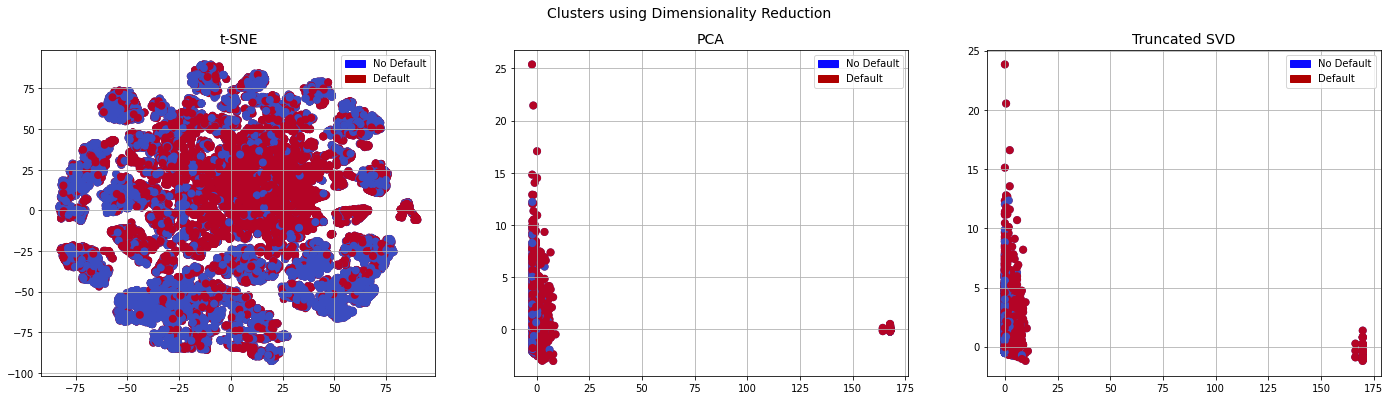

In [160]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Default', 'Default']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Default')
red_patch = mpatches.Patch(color='#AF0000', label='Default')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Default', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Default', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Default', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Default', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Default', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Default', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

Classifiers (UnderSampling):

In [161]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('SeriousDlqin2yrs', axis=1)
y = new_df['SeriousDlqin2yrs']

In [162]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [164]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [165]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 71.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 72.0 % accuracy score
Classifiers:  SVC Has a training score of 75.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 69.0 % accuracy score


In [166]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# log_reg best estimator
log_reg = grid_log_reg.best_estimator_
# kNN classifier
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [167]:
# Overfitting Case
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  70.88%
Knears Neighbors Cross Validation Score 71.1%
Support Vector Classifier Cross Validation Score 74.55%
DecisionTree Classifier Cross Validation Score 74.81%


In [168]:
# We will undersample during cross validating
undersample_X = df.drop('SeriousDlqin2yrs', axis=1)
undersample_y = df['SeriousDlqin2yrs']
undersample_X.scaled_MonthlyIncome = undersample_X.scaled_MonthlyIncome.fillna(undersample_X.scaled_MonthlyIncome.median())
undersample_X.NumberOfDependents = undersample_X.NumberOfDependents.fillna(undersample_X.NumberOfDependents.median())

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 29931  29932  29933 ... 149997 149998 149999] Test: [    0     1     2 ... 30887 30945 30986]
Train: [     0      1      2 ... 149997 149998 149999] Test: [29931 29932 29933 ... 60044 60047 60053]
Train: [     0      1      2 ... 149997 149998 149999] Test: [59995 59996 59997 ... 90908 90961 90962]
Train: [     0      1      2 ... 149997 149998 149999] Test: [ 89945  89946  89947 ... 120571 120572 120576]
Train: [     0      1      2 ... 120571 120572 120576] Test: [119958 119959 119960 ... 149997 149998 149999]
NearMiss Label Distribution: Counter({0: 10026, 1: 10026})


In [169]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

In [170]:
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
#plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [171]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [172]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.7846077798065213
KNears Neighbors:  0.7105890729716232
Support Vector Classifier:  0.8192147123888337
Decision Tree Classifier:  0.7485088543013448


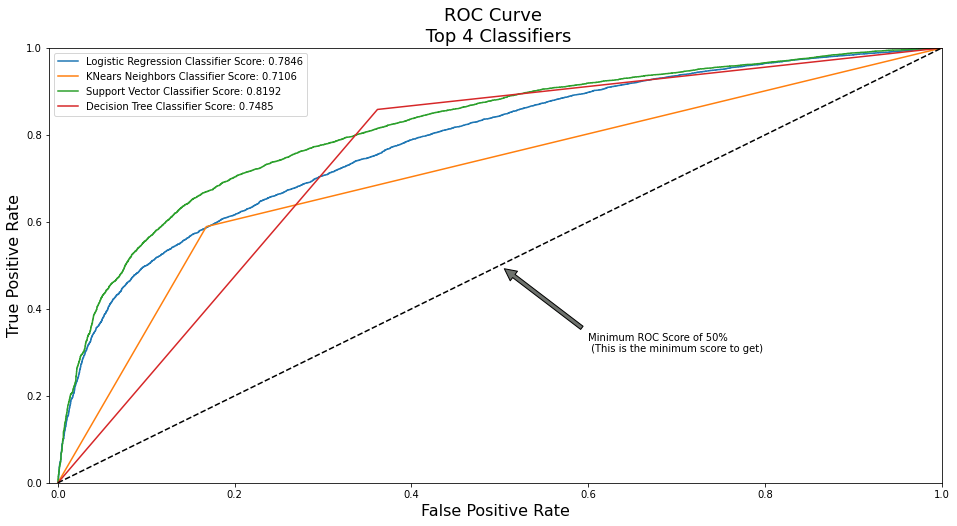

In [173]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [174]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [175]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.93
Precision Score: 0.50
F1 Score: 0.65
Accuracy Score: 0.50
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.12
Precision Score: 0.07
Recall Score: 0.73
F1 Score: 0.13
---------------------------------------------------------------------------------------------------------------------------------------


In [176]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [177]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.09


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.09')

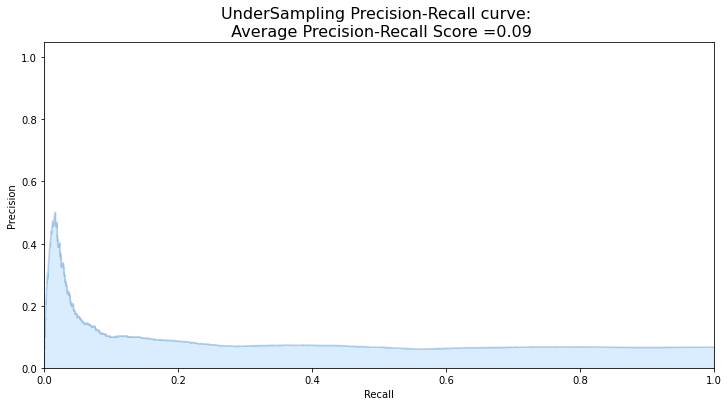

In [178]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

SMOTE Technique (Over-Sampling):

SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

It picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

Here, more information is retained since we didn't have to delete any rows unlike in random undersampling.

Accuracy || Time Tradeoff: Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

In [179]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 120000 | Length of y (train): 120000
Length of X (test): 30000 | Length of y (test): 30000
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.7552916666666667
precision: 0.16466056035926563
recall: 0.6529105584947289
f1: 0.2629682705868007
---------------------------------------------------------------------------------------------------------------------------------------


In [180]:
labels = ['No Default', 'Default']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

  No Default       0.97      0.75      0.85     27995
     Default       0.16      0.67      0.26      2005

    accuracy                           0.75     30000
   macro avg       0.57      0.71      0.55     30000
weighted avg       0.92      0.75      0.81     30000



In [181]:
y_score = best_est.decision_function(original_Xtest)

In [182]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.29


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.29')

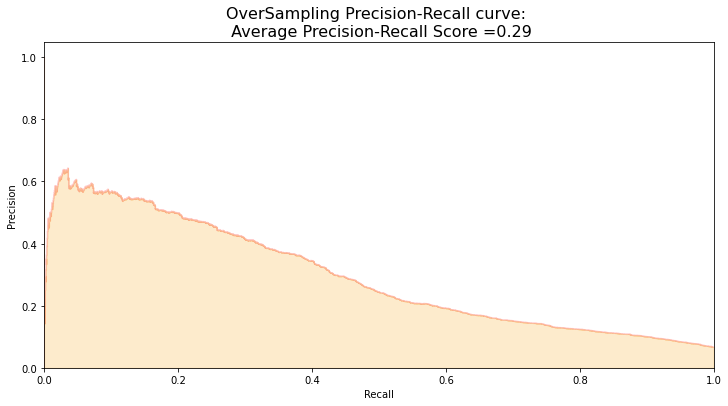

In [183]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [184]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [185]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :0.8078110218048096 sec


Test Data with Logistic Regression:

We will evaluate the final performance of the classification models in the random undersampling subset (this is not the data from the original dataframe).The models that performed the best were logistic regression and support vector classifier (SVM).

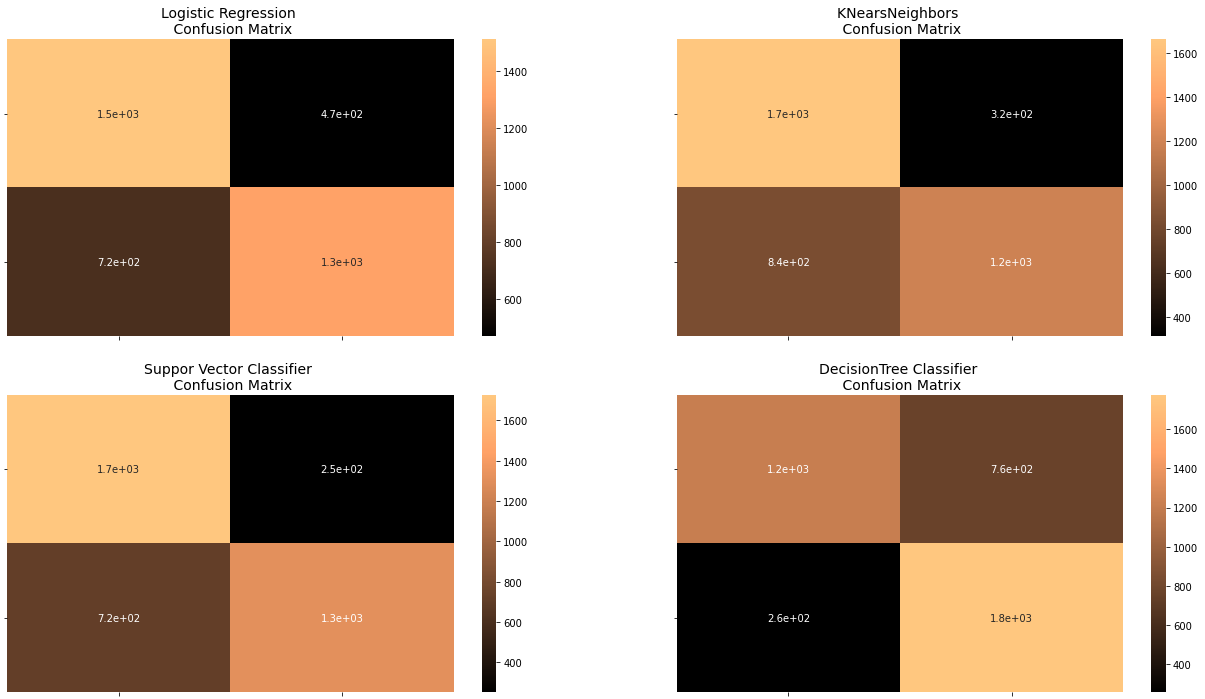

In [186]:
from sklearn.metrics import confusion_matrix
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)
# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [187]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1979
           1       0.74      0.65      0.69      2032

    accuracy                           0.70      4011
   macro avg       0.71      0.70      0.70      4011
weighted avg       0.71      0.70      0.70      4011

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      1979
           1       0.79      0.59      0.67      2032

    accuracy                           0.71      4011
   macro avg       0.73      0.71      0.71      4011
weighted avg       0.73      0.71      0.71      4011

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1979
           1       0.84      0.65      0.73      2032

    accuracy                           0.76      4011
   macro avg       0.77      0.76      0.76      4011
weighted

In [188]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Technique,Score
0,Random UnderSampling,0.704064
1,Oversampling (SMOTE),0.745167


Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE):

In this phase of testing we will fit this model in both the random undersampled subset and oversampled dataset (SMOTE) in order to predict the final result using the original dataframe testing data. As stated previously, this will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No default or default). The learning rate will be 0.001, the optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is no fraud or fraud (The prediction will pick the highest probability between the two).

In [190]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 528
Trainable params: 528
Non-trainable params: 0
_________________________________________________________________


In [191]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [192]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 12832 samples, validate on 3209 samples
Epoch 1/20
 - 1s - loss: 0.6027 - accuracy: 0.7032 - val_loss: 0.5662 - val_accuracy: 0.7442
Epoch 2/20
 - 1s - loss: 0.5507 - accuracy: 0.7435 - val_loss: 0.5368 - val_accuracy: 0.7566
Epoch 3/20
 - 1s - loss: 0.5322 - accuracy: 0.7489 - val_loss: 0.5244 - val_accuracy: 0.7591
Epoch 4/20
 - 1s - loss: 0.5269 - accuracy: 0.7517 - val_loss: 0.5225 - val_accuracy: 0.7622
Epoch 5/20
 - 1s - loss: 0.5209 - accuracy: 0.7530 - val_loss: 0.5168 - val_accuracy: 0.7616
Epoch 6/20
 - 1s - loss: 0.5186 - accuracy: 0.7547 - val_loss: 0.5135 - val_accuracy: 0.7653
Epoch 7/20
 - 1s - loss: 0.5147 - accuracy: 0.7574 - val_loss: 0.5269 - val_accuracy: 0.7560
Epoch 8/20
 - 1s - loss: 0.5143 - accuracy: 0.7563 - val_loss: 0.5158 - val_accuracy: 0.7622
Epoch 9/20
 - 1s - loss: 0.5126 - accuracy: 0.7560 - val_loss: 0.5134 - val_accuracy: 0.7660
Epoch 10/20
 - 1s - loss: 0.5140 - accuracy: 0.7576 - val_loss: 0.5109 - val_accuracy: 0.7650
Epoch 11/20
 - 1s - 

In [193]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [194]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [195]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22145  5850]
 [  514  1491]]
Confusion matrix, without normalization
[[27995     0]
 [    0  2005]]


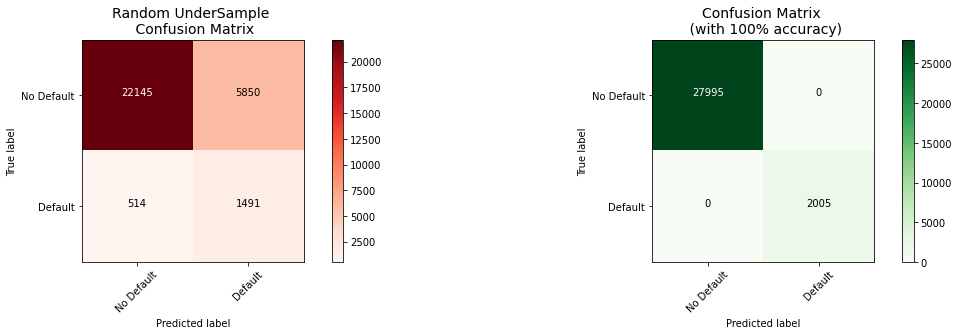

In [196]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Default', 'Default']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [197]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [198]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [200]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=30, epochs=20, shuffle=True, verbose=2)

Train on 179166 samples, validate on 44792 samples
Epoch 1/20
 - 8s - loss: 0.4773 - accuracy: 0.7834 - val_loss: 0.7317 - val_accuracy: 0.6010
Epoch 2/20
 - 8s - loss: 0.4750 - accuracy: 0.7845 - val_loss: 0.6854 - val_accuracy: 0.6191
Epoch 3/20
 - 8s - loss: 0.4743 - accuracy: 0.7844 - val_loss: 0.7326 - val_accuracy: 0.5939
Epoch 4/20
 - 8s - loss: 0.4737 - accuracy: 0.7844 - val_loss: 0.6380 - val_accuracy: 0.6384
Epoch 5/20
 - 8s - loss: 0.4730 - accuracy: 0.7848 - val_loss: 0.6692 - val_accuracy: 0.6458
Epoch 6/20
 - 8s - loss: 0.4722 - accuracy: 0.7852 - val_loss: 0.6888 - val_accuracy: 0.6271
Epoch 7/20
 - 8s - loss: 0.4713 - accuracy: 0.7856 - val_loss: 0.6701 - val_accuracy: 0.6301
Epoch 8/20
 - 8s - loss: 0.4710 - accuracy: 0.7856 - val_loss: 0.6853 - val_accuracy: 0.6374
Epoch 9/20
 - 8s - loss: 0.4702 - accuracy: 0.7864 - val_loss: 0.6778 - val_accuracy: 0.6268
Epoch 10/20
 - 8s - loss: 0.4696 - accuracy: 0.7869 - val_loss: 0.6447 - val_accuracy: 0.6352
Epoch 11/20
 - 9s 

In [201]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [202]:
oversample_default_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[24351  3644]
 [  673  1332]]
Confusion matrix, without normalization
[[27995     0]
 [    0  2005]]


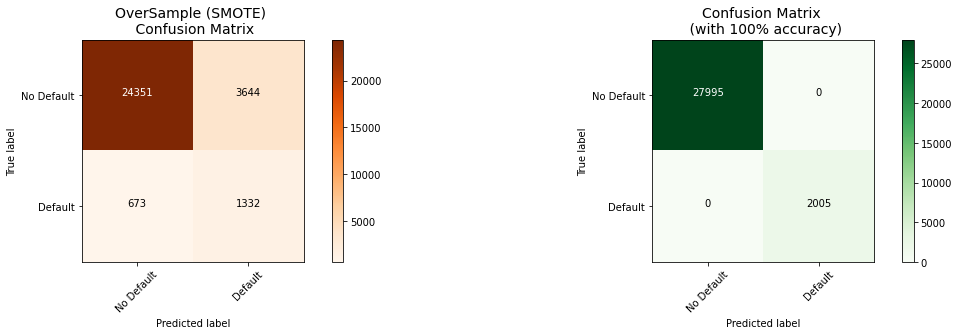

In [204]:
oversample_smote = confusion_matrix(original_ytest, oversample_default_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Default', 'Default']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

Conclusion:

Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more no default than default transactions). Nonetheless, I still have to state that sometimes the neural network on the oversampled dataset predicts less correct default transactions than our model using the undersample dataset. However, remember that the removal of outliers was implemented only on the random undersample dataset and not on the oversampled one. Also, in our undersample data our model is unable to detect for a large number of cases non default transactions correctly and instead, misclassifies those non default transactions as default cases. The next step of this analysis will be to do an outlier removal on our oversample dataset and see if our accuracy in the test set improves.